# Исследование популярного сервиса аренды самокатов GoFast

# Описание проекта

Есть данные о некоторых пользователях из нескольких городов, а также об их поездках. Нужно проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

без подписки

    абонентская плата отсутствует;
    стоимость одной минуты поездки — 8 рублей;
    стоимость старта (начала поездки) — 50 рублей;
    
с подпиской Ultra

    абонентская плата — 199 рублей в месяц;
    стоимость одной минуты поездки — 6 рублей;
    стоимость старта — бесплатно.

# Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — users_go.csv

    user_id	уникальный идентификатор пользователя
    name	имя пользователя
    age	возраст
    city	город
    subscription_type	тип подписки (free, ultra)
    
Поездки — rides_go.csv

    user_id	уникальный идентификатор пользователя
    distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
    duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до     момента, как он нажал кнопку «Завершить поездку»
    date	дата совершения поездки
    
Подписки — subscriptions_go.csv

    subscription_type	тип подписки
    minute_price	стоимость одной минуты поездки по данной подписке
    start_ride_price	стоимость начала поездки
    subscription_fee	стоимость ежемесячного платежа

## Шаг 1. Загрузка данных

### Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы. Пути к файлам:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
users_go = pd.read_csv('/datasets/users_go.csv')
rides_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

### Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

In [2]:
users_go.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [3]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
rides_go.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [5]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:** users_go - 1565 строк, rides_go - date требуется привести к временному типу, 18068 записей, subscriptions_go - 2 записи.

## Шаг 2. Предобработка данных

### Приведите столбец date к типу даты pandas.

In [8]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%dT%H:%M:%S')

### Создайте новый столбец с номером месяца на основе столбца date.

In [9]:
rides_go['month'] = rides_go['date'].dt.month

### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

In [10]:
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [11]:
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [12]:
subscriptions_go.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Вывод:** пропусков нет.

In [13]:
users_go.duplicated().sum()
users_go = users_go.drop_duplicates()
users_go = users_go.reset_index(drop=True)

In [14]:
rides_go.duplicated().sum()

0

In [15]:
subscriptions_go.duplicated().sum()

0

In [16]:
users_go.duplicated().sum()

0

**Вывод:** избавились от явных дубликатов.

In [17]:
users_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [18]:
users_go[users_go.duplicated(['user_id'])].sum() # дубликатов по user_id нет

user_id              0.0
name                 0.0
age                  0.0
city                 0.0
subscription_type    0.0
dtype: float64

Неявных дубликатов не выявила.

**Вывод:** Столбец date привели к нужному типу. Проверили наличие пропусков и дубликатов, обработали. Можно приступать к анализу.

## Шаг 3. Исследовательский анализ данных

### Частота встречаемости городов

In [19]:
users_go['user_id'].describe()

count    1534.000000
mean      767.500000
std       442.971971
min         1.000000
25%       384.250000
50%       767.500000
75%      1150.750000
max      1534.000000
Name: user_id, dtype: float64

In [20]:
users_go_city = users_go.pivot_table(index='city', values='user_id', aggfunc='count')
users_go_city.sort_values('user_id', ascending=False)

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


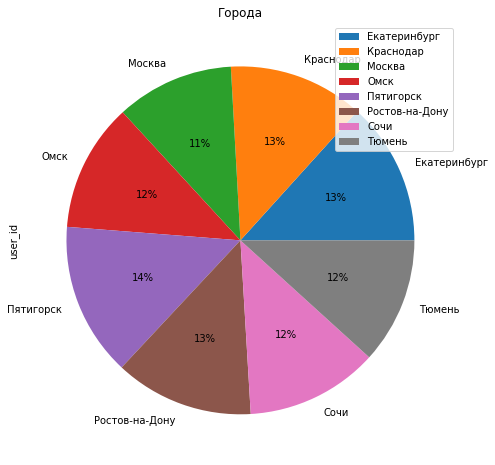

In [21]:
users_go_city.plot(kind='pie', figsize=(8, 8), y='user_id', autopct = '%1.0f%%')
plt.title('Города')
plt.show() 

**Вывод:** Чаще всего встречается город Екатеринбург - 204 пользователя, меньше всего Тюмень - 180.

### Соотношение пользователей с подпиской и без подписки

In [22]:
users_go_subscription_type = users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
users_go_subscription_type.sort_values('user_id', ascending=False)

,user_id
subscription_type,
free,835
ultra,699


In [23]:
all_users = users_go_subscription_type['user_id'].sum()
all_users

1534

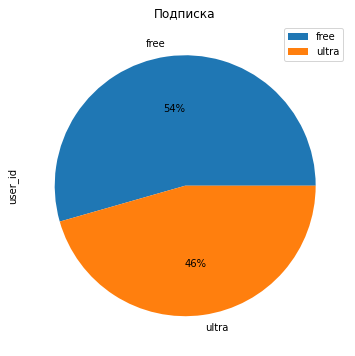

In [24]:
users_go_subscription_type.plot(kind='pie', figsize=(6, 6), y='user_id', autopct = '%1.0f%%')
plt.title('Подписка')
plt.show() 

**Вывод:** Всего клиентов 1534. Доля клиентов без подписки - 54% (835). С подпиской - 46% (699).

### Возраст пользователей

In [25]:
users_go['age'].value_counts()

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

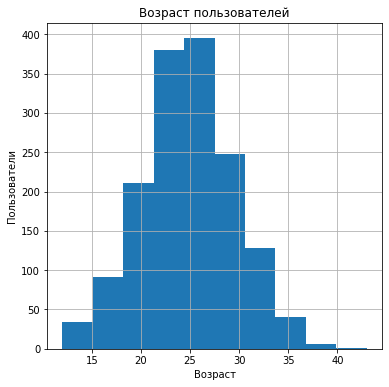

In [26]:
users_go['age'].plot(kind='hist', figsize=(6, 6), grid=True)
plt.title('Возраст пользователей')
plt.ylabel('Пользователи')
plt.xlabel('Возраст')
plt.show()

**Вывод:** Можно отметить, что чаще всего сервисом пользуются клиенты с возрастом от 22 до 27 лет примерно. Чаще всего встречается возраст 25 лет - 145 клиентов.

### Расстояние, которое пользователь преодолел за одну поездку

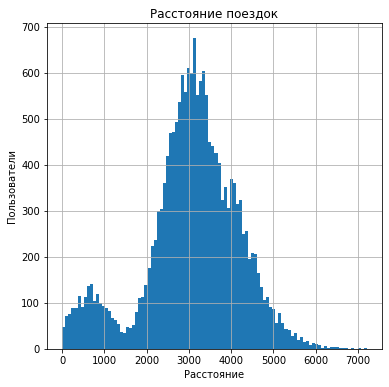

In [27]:
rides_go['distance'].plot(kind='hist', figsize=(6, 6), grid=True, bins=100)
plt.title('Расстояние поездок')
plt.ylabel('Пользователи')
plt.xlabel('Расстояние')
plt.show()

In [28]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

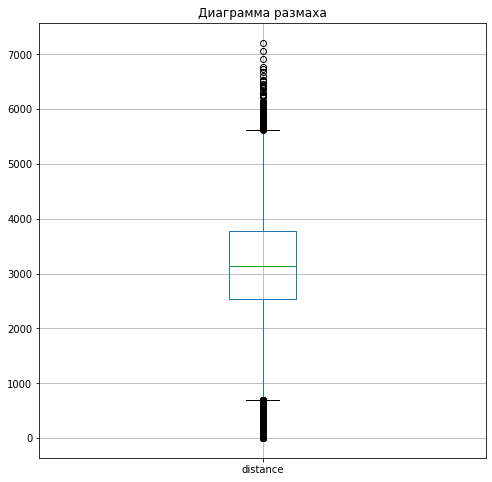

In [29]:
rides_go.boxplot('distance', figsize=(8, 8))
plt.title('Диаграмма размаха')
plt.show()

**Вывод:** Можно отметить, что присутствуют выбросы. Минимальное расстояние - 0,85, максимальное - 7211. В среднем расстояние около 3000 - 4000 м.

### Продолжительность поездок

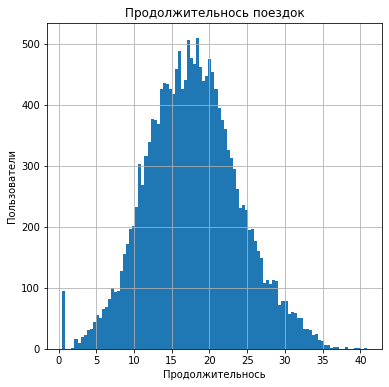

In [30]:
rides_go['duration'].plot(kind='hist', figsize=(6, 6), grid=True, bins=100)
plt.title('Продолжительнось поездок')
plt.ylabel('Пользователи')
plt.xlabel('Продолжительнось')
plt.show()

In [31]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

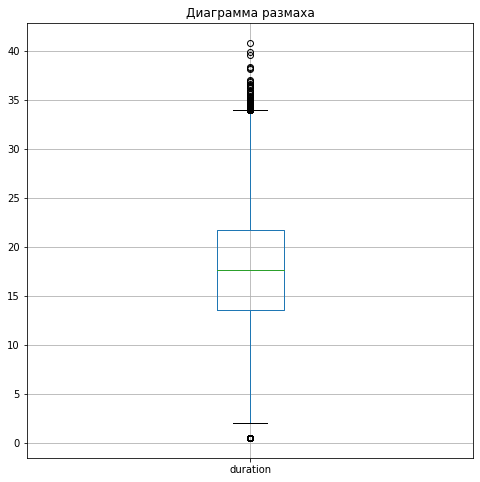

In [32]:
rides_go.boxplot('duration', figsize=(8, 8))
plt.title('Диаграмма размаха')
plt.show()

**Вывод:** Можно отметить выбросы на 0. Очень странно. Минимальная поездка - 0,5. Максимальная продолжительность - 40,8 мин. В среднем время поездки около 17 минут. Значение адекватное.

**Общий вывод:**

Чаще всего встречается город Екатеринбург - 204 пользователя, меньше всего Тюмень - 180.

Всего клиентов 1534. Доля клиентов без подписки - 54% (835). С подпиской - 46% (699).

Чаще всего сервисом пользуются клиенты с возрастом от 22 до 27 лет примерно. Чаще всего встречается возраст 25 лет - 145 клиентов.

Минимальное расстояние - 0,85, максимальное - 7211. В среднем расстояние около 3000 - 4000 м.

Минимальная поездка - 0,5. Максимальная продолжительность - 40,8 мин. В среднем время поездки около 17 минут. Значение адекватное.

## Шаг 4. Объединение данных

### Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge()

In [33]:
df = users_go.merge(rides_go, on='user_id')

In [34]:
df = df.merge(subscriptions_go, on='subscription_type')

In [35]:
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


**Вывод:** Датафреймы объеденены успешно.

### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
    c данными о пользователях без подписки;
    с данными о пользователях с подпиской.


In [36]:
df_ultra = df.query('subscription_type=="ultra"')

In [37]:
df_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [38]:
df_free = df.query('subscription_type=="free"')

In [39]:
df_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


**Вывод:** Датафреймы созданы. df_ultra - с подпиской, df_free - без подписки.

### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

**Пользователи с подпиской**

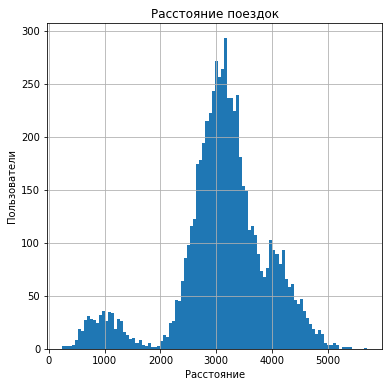

In [40]:
df_ultra['distance'].plot(kind='hist', figsize=(6, 6), grid=True, bins=100)
plt.title('Расстояние поездок')
plt.ylabel('Пользователи')
plt.xlabel('Расстояние')
plt.show()

In [41]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

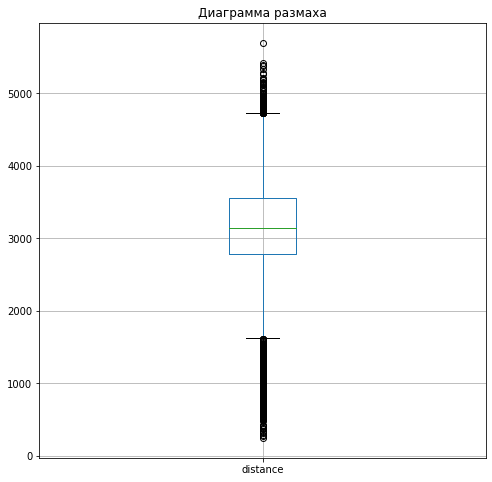

In [42]:
df_ultra.boxplot('distance', figsize=(8, 8))
plt.title('Диаграмма размаха')
plt.show()

**Вывод:** Наименьшая дистанция - 244м, максимальная - 5699. Выбросы есть, однако значений дистанций около 0 нет. Средняя дистанция - около 3110 м.

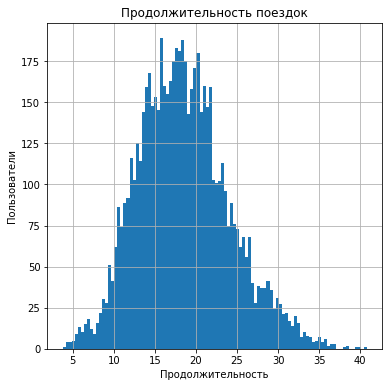

In [43]:
df_ultra['duration'].plot(kind='hist', figsize=(6, 6), grid=True, bins=100)
plt.title('Продолжительность поездок')
plt.ylabel('Пользователи')
plt.xlabel('Продолжительность')
plt.show()

In [44]:
df_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

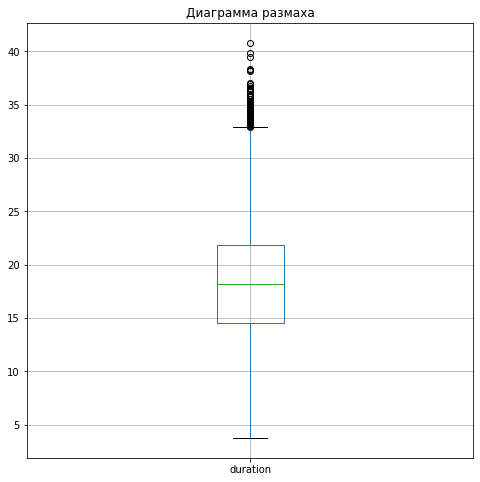

In [45]:
df_ultra.boxplot('duration', figsize=(8, 8))
plt.title('Диаграмма размаха')
plt.show()

**Вывод:** Минимальное значение 3 мин, максимальное - 40 минут. Распределение в целом нормальное.

**Пользователи без подписки**

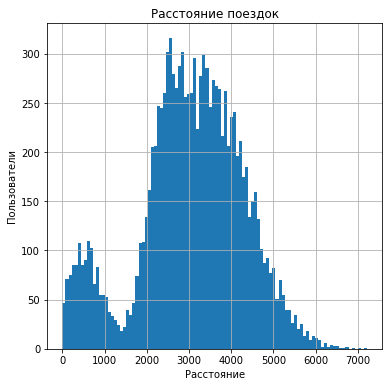

In [46]:
df_free['distance'].plot(kind='hist', figsize=(6, 6), grid=True, bins=100)
plt.title('Расстояние поездок')
plt.ylabel('Пользователи')
plt.xlabel('Расстояние')
plt.show()

In [47]:
df_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

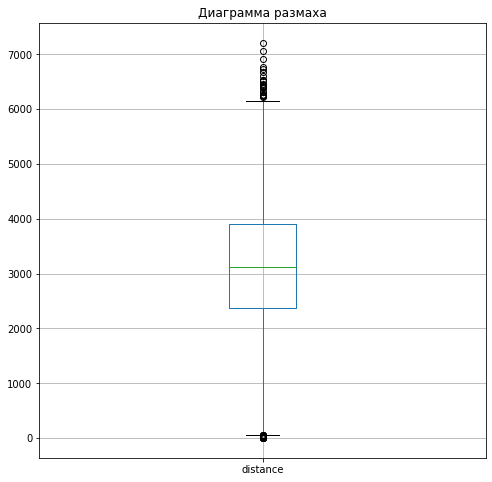

In [48]:
df_free.boxplot('distance', figsize=(8, 8))
plt.title('Диаграмма размаха')
plt.show()

**Вывод:** Минимальное значение - 0,8, максимальное - 7211 м. Можно сделать выводы, что выбросы в районе 0 именно у клиентов, которые без подписки.

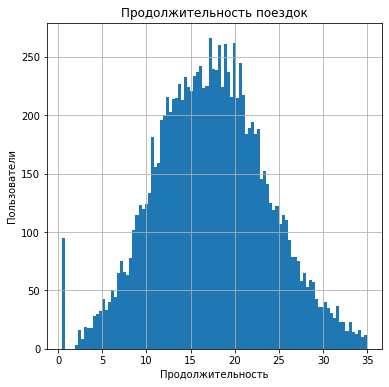

In [49]:
df_free['duration'].plot(kind='hist', figsize=(6, 6), grid=True, bins=100)
plt.title('Продолжительность поездок')
plt.ylabel('Пользователи')
plt.xlabel('Продолжительность')
plt.show()

In [50]:
df_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

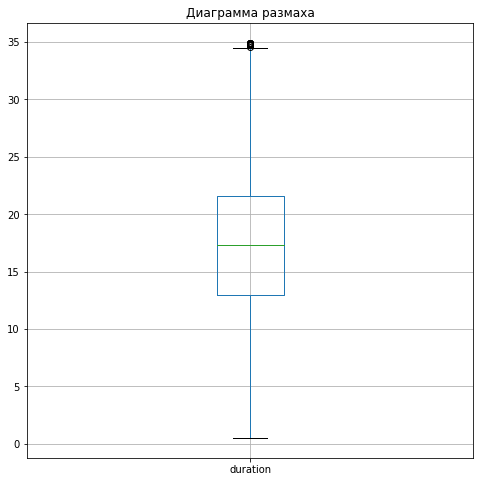

In [51]:
df_free.boxplot('duration', figsize=(8, 8))
plt.title('Диаграмма размаха')
plt.show()

**Вывод:** Минимальное значение - 0,5. Максимальное - 34,9 мин. Опять таки выбросы в районе нулей. Предположительно, что это именно одни и те же поездки

In [52]:
df_free.query('duration<=0.5')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6531,701,Иван,31,Екатеринбург,free,4196.445201,0.5,2021-08-31,8,8,50,0
6570,704,Мирон,29,Ростов-на-Дону,free,4830.824371,0.5,2021-10-14,10,8,50,0
6680,712,Дарья,28,Москва,free,4684.004397,0.5,2021-03-04,3,8,50,0
6695,713,Святослав,30,Краснодар,free,5215.642710,0.5,2021-02-25,2,8,50,0
6768,718,Владислава,31,Москва,free,5197.436649,0.5,2021-02-11,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17004,1460,Жанна,27,Пятигорск,free,5531.335845,0.5,2021-01-19,1,8,50,0
17242,1477,Ян,17,Сочи,free,6724.932981,0.5,2021-01-12,1,8,50,0
17314,1483,Роберт,26,Екатеринбург,free,4445.481070,0.5,2021-03-06,3,8,50,0
17505,1496,Яна,19,Москва,free,5722.551787,0.5,2021-02-14,2,8,50,0


**Вывод:** Можно отметить, что есть поездки при дистанции 3-4 тыс. метров, но при этом продолжительность 0,5. Очень похоже на сбой. Всего поездок с временем 0,5 - 95. При этом дистанции там больше 4000 м.

In [53]:
df_free.query('distance<=10')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
7841,796,Алексей,25,Екатеринбург,free,7.097072,10.026614,2021-11-26,11,8,50,0
8658,861,Мария,27,Краснодар,free,6.784447,6.015656,2021-07-21,7,8,50,0
9541,925,Всеволод,28,Ростов-на-Дону,free,2.570787,3.011018,2021-10-19,10,8,50,0
11555,1069,Степан,20,Сочи,free,0.855683,10.001902,2021-01-31,1,8,50,0
13690,1223,Злата,22,Тюмень,free,4.329506,4.008958,2021-05-22,5,8,50,0


**Вывод:** С дистанцией меньше 10 метров - 5 поездок. Возможно клиенты включали и выключали самокат. В целом с продолжительностью всё ок.

**Общий вывод:**

Датафреймы объеденены успешно.

Датафреймы созданы. df_ultra - с подпиской, df_free - без подписки.

**Пользователи с подпиской:**

Наименьшая дистанция - 244м, максимальная - 5699. Выбросы есть, однако значений дистанций около 0 нет. Средняя дистанция - около 3110 м.

Минимальное значение 3 мин, максимальное - 40 минут. Распределение в целом нормальное.

**Пользователи без подписки:**

Минимальное значение - 0,8, максимальное - 7211 м. Можно сделать выводы, что выбросы в районе 0 именно у клиентов, которые без подписки.

Можно отметить, что есть поездки при дистанции 3-4 тыс. метров, но при этом продолжительность 0,5. Очень похоже на сбой. Всего поездок с временем 0,5 - 95. При этом дистанции там больше 4000 м.

С дистанцией меньше 10 метров - 5 поездок. Возможно клиенты включали и выключали самокат. В целом с продолжительностью всё ок.

В целом среднее значение дистанций примерно одинаковые. Средняя продолжительность 17 минут у пользователей без подписки, 18 - с подпиской. Разницы практически нет.

## Шаг 5. Подсчёт выручки

### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [54]:
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [55]:
df_revenue = df.pivot_table(
    index=['user_id', 'month'], 
    values=['name', 'distance','duration', 'subscription_type'], 
    aggfunc={'name' : 'count', 'distance': 'sum', 'duration' : 'sum', 'subscription_type' : 'min'})

### В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь

In [56]:
df_revenue['duration'] = np.ceil(df_revenue['duration']) # округляем значение продолжительности

In [57]:
df_revenue.head()

distance  duration  name subscription_type
user_id month                                               
1       1      7027.511294      42.0     2             ultra
        4       754.159807       7.0     1             ultra
        8      6723.470560      45.0     2             ultra
        10     5809.911100      32.0     2             ultra
        11     7003.499363      54.0     3             ultra

In [58]:
def revenue(row):
    if row['subscription_type'] == 'free':
        return 50 * row['duration'] + 8 * row['duration']
    elif row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199

In [59]:
df_revenue['revenue'] = df_revenue.apply(revenue, axis=1)

In [60]:
df_revenue.head()

distance  duration  name subscription_type  revenue
user_id month                                                        
1       1      7027.511294      42.0     2             ultra    451.0
        4       754.159807       7.0     1             ultra    241.0
        8      6723.470560      45.0     2             ultra    469.0
        10     5809.911100      32.0     2             ultra    391.0
        11     7003.499363      54.0     3             ultra    523.0

In [61]:
df_revenue.describe()

,distance,duration,name,revenue
count,11331.000000,11331.000000,11331.000000,11331.000000
mean,4896.362584,28.888889,1.594564,1191.821287
std,2911.516556,16.382916,0.831604,1038.896699
min,2.570787,1.000000,1.000000,58.000000
25%,2972.202146,17.000000,1.000000,355.000000
50%,3988.723985,24.000000,1.000000,870.000000
75%,6421.375890,37.000000,2.000000,1682.000000
max,23429.487786,141.000000,7.000000,8178.000000


**Общий вывод:** Создали датафрейм с агрегированными данными о поездках. Посчитали выручку на каждого клиента по каждому месяцу. Средняя выручка составила 1191 р, медина - 870, разница есть. 

## Шаг 6. Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки

H_0 (нулевая гипотеза): Продолжительность duration пользователей с подпиской ultra = Продолжительность duration пользователей без подписки free

H_1 (альтернативная гипотеза): Продолжительность duration пользователей с подпиской ultra не равна Продолжительность duration пользователей без подписки free

In [62]:
ultra = df_ultra['duration']
free = df_free['duration']

alpha = 0.05

results = st.ttest_ind(ultra, free, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Вывод:** Отвергаем нулевую гипотезу в пользу альтернативной. Можем согласиться, что пользователи с подпиской тратят времени не столько же, как пользователи без подписки.

### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

H_0 (нулевая гипотеза): Расстояние поездки клиента с подпиской равна 3130

H_1 (альтернативная гипотеза): Расстояние поездки клиента с подпиской меньше 3130

In [63]:
ultra = df_ultra['distance']

interested_value = 3130

alpha = 0.05

results = st.ttest_1samp(ultra, interested_value, alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Не получилось отвергнуть нулевую гипотезу. Можем предполагать, что расстояние одной поездки пользователя с подпиской не больше 3130 метров.

### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

H_0 (нулевая гипотеза): Выручка пользователей с подпиской = выручка пользователей без подписки

H_1 (альтернативная гипотеза): Выручка пользователей с подпиской > выручка пользователей без подписки

In [66]:
ultra = df_revenue.query('subscription_type == "ultra"').loc[:, 'revenue']
free = df_revenue.query('subscription_type == "free"').loc[:, 'revenue']

alpha = 0.05

results = st.ttest_ind(ultra, free, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Не получилось отвергнуть нулевую гипотезу. Мы не можем утверждать, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Гипотеза о равенстве средних для зависимых (парных) выборок

H_0 (нулевая гипотеза): Количество обращений до и после обновления равны

H_1 (альтернативная гипотеза): Количество обращений после обновления стало меньше

st.ttest_rel(before, after)

# Общий вывод

Посмотрели общую информацию о данных, проверили наличие пропусков и дубликатов, обработали.

**Исследовательский анализ**

Чаще всего встречается город Екатеринбург - 204 пользователя, меньше всего Тюмень - 180.

Всего клиентов 1534. Доля клиентов без подписки - 54% (835). С подпиской - 46% (699).

Чаще всего сервисом пользуются клиенты с возрастом от 22 до 27 лет примерно. Чаще всего встречается возраст 25 лет - 145 клиентов.

Минимальное расстояние - 0,85, максимальное - 7211. В среднем расстояние около 3000 - 4000 м.

Минимальная поездка - 0,5. Максимальная продолжительность - 40,8 мин. В среднем время поездки около 17 минут. Значение адекватное.

Датафреймы созданы. df_ultra - с подпиской, df_free - без подписки.



Пользователи с подпиской:

Наименьшая дистанция - 244м, максимальная - 5699. Выбросы есть, однако значений дистанций около 0 нет. Средняя дистанция - около 3110 м.

Минимальное значение 3 мин, максимальное - 40 минут. Распределение в целом нормальное.

Пользователи без подписки:

Минимальное значение - 0,8, максимальное - 7211 м. Можно сделать выводы, что выбросы в районе 0 именно у клиентов, которые без подписки.

Можно отметить, что есть поездки при дистанции 3-4 тыс. метров, но при этом продолжительность 0,5. Очень похоже на сбой. Всего поездок с временем 0,5 - 95. При этом дистанции там больше 4000 м.

С дистанцией меньше 10 метров - 5 поездок. Возможно клиенты включали и выключали самокат. В целом с продолжительностью всё ок.

В целом среднее значение дистанций примерно одинаковые. Средняя продолжительность 17 минут у пользователей без подписки, 18 - с подпиской. Разницы практически нет.

**Проверка гипотез**

Можем согласиться, что пользователи с подпиской тратят времени не столько же, как пользователи без подписки.

Можем предполагать, что расстояние одной поездки пользователя с подпиской не больше 3130 метров.

Мы не можем утверждать, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.